In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
import numpy as np
from IPython.display import display, Markdown
sns.set_context('talk')

In [2]:
df = pd.read_csv('timings_cpp.csv.gz')
df['unique_ratio'] = df.n_unique / df.n_total
df['key_width'] = df.key_type.apply(lambda x: int(re.sub('^u?int', '', x)))
df['time'] = 1e9 * df.pop('time')
df['time_per_item'] = df.time / df.n_total
df['ops'] = df.c_default + df.c_copy + df.c_move + df.c_move_assign + df.c_less + df.c_hash + df.c_equals
df['ops_per_item'] = df.ops / df.n_total
df['logic_ops'] = df.c_less + df.c_hash + df.c_equals
df['logic_ops_per_item'] = df.logic_ops / df.n_total
df['data_ops'] = df.c_default + df.c_copy + df.c_move + df.c_move_assign
df['data_ops_per_item'] = df.data_ops / df.n_total

dfm = df.groupby(['key_type', 'n_total', 'n_unique', 'method']).median().reset_index()

# Results

In [24]:
display(dfm[(dfm.n_total == 2 ** 20) & (dfm.key_type == 'int32') & (dfm.unique_ratio == .5)][
    ['method', 'time_per_item', 'data_ops_per_item', 'logic_ops_per_item']].set_index(['method']))

d = dfm[dfm.key_type == 'int32'][['method', 'n_total', 'unique_ratio', 'time_per_item']]
display(pd.pivot_table(
    d[((d.n_total == d.n_total.max()) & (d.unique_ratio == 1)) |
      ((d.n_total == 2 ** 20) & (d.unique_ratio == .5)) |
      ((d.n_total == 2 ** 16) & (d.unique_ratio == d.unique_ratio.min()))
     ],
    values='time_per_item',
    index=['n_total', 'unique_ratio'],
    columns=['method']))

,time_per_item,data_ops_per_item,logic_ops_per_item
method,,,
custom_hash_unique,88.536072,1.499992,6.067007
hash_unique,192.767143,1.000000,1.500000
sort_unique,125.318527,17.924194,24.670032


,method,custom_hash_unique,hash_unique,sort_unique
n_total,unique_ratio,,,
65536,0.015625,42.093735,20.680389,74.852982
1048576,0.500000,88.536072,192.767143,125.318527
16777216,1.000000,179.789066,516.802967,142.988861


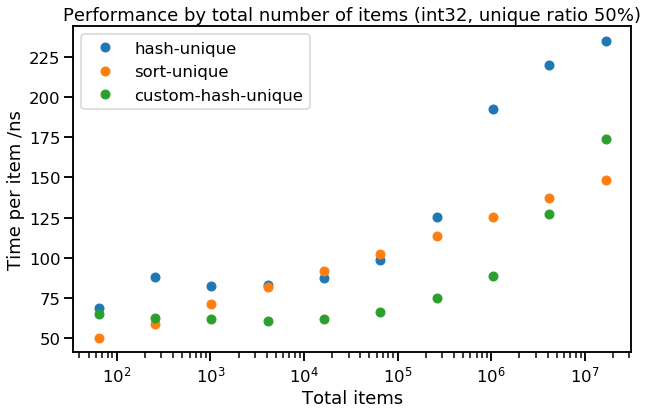

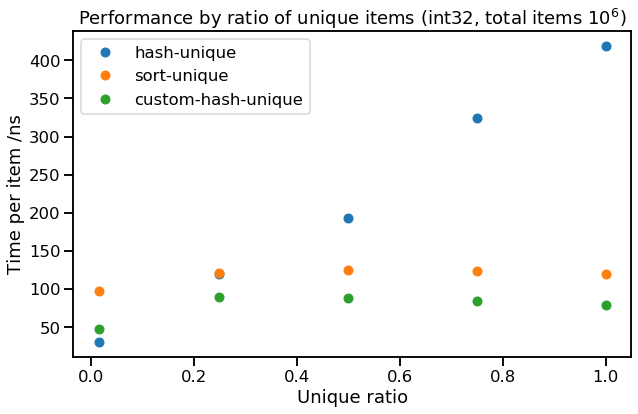

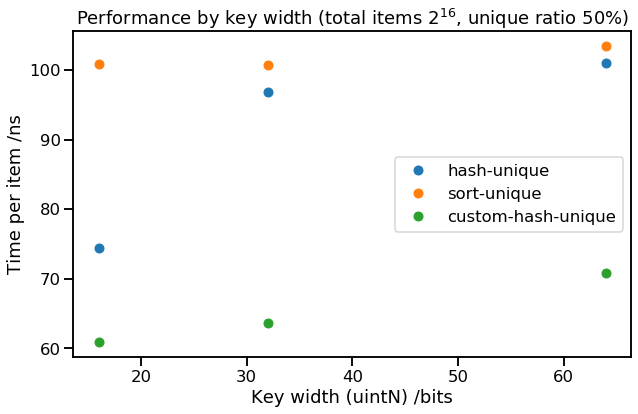

In [5]:
methods = ['hash_unique', 'sort_unique', 'custom_hash_unique']

plt.figure(figsize=(10,6))
d = dfm[(dfm.key_type == 'int32') & (dfm.unique_ratio == .5)]
for method in methods:
    g = d[d.method == method]
    plt.plot(g.n_total, g.time_per_item, 'o')
plt.gca().set_xscale('log')
plt.legend([x.replace('_', '-') for x in methods])
plt.title('Performance by total number of items (int32, unique ratio 50%)')
plt.xlabel('Total items')
plt.ylabel('Time per item /ns')

plt.figure(figsize=(10,6))
d = dfm[(dfm.key_type == 'int32') & (dfm.n_total == 2 ** 20)]
for method in methods:
    g = d[d.method == method]
    plt.plot(g.unique_ratio, g.time_per_item, 'o')
plt.legend([x.replace('_', '-') for x in methods])
plt.title('Performance by ratio of unique items (int32, total items $10^6$)')
plt.xlabel('Unique ratio')
plt.ylabel('Time per item /ns')

plt.figure(figsize=(10,6))
d = dfm[dfm.key_type.apply(lambda x: x.startswith('uint')) & (dfm.n_total == 2 ** 16) & (dfm.unique_ratio == .5)]
for method in methods:
    g = d[d.method == method]
    plt.plot(g.key_width, g.time_per_item, 'o')
plt.legend([x.replace('_', '-') for x in methods])
plt.title('Performance by key width (total items $2^{16}$, unique ratio 50%)')
plt.xlabel('Key width (uintN) /bits')
plt.ylabel('Time per item /ns');

# Linear model

In [25]:
rows = []
for method in ['sort_unique', 'hash_unique', 'custom_hash_unique']:
    d = df[df.method == method]
    f = np.stack((
        np.ones_like(d.n_total),
        d.n_total,
        d.n_total * np.log(d.n_total),
        d.n_unique,
        d.n_unique * np.log(d.n_unique)
    ))
    f_names = ['', 'N', r'N \log N', 'N_{unique}', r'N_{unique} \log N_{unique}']
    y = np.array(d.time)
    opt = sp.optimize.least_squares(
        lambda x: (x @ f) - y,
        x0=np.ones(f.shape[0]),
        loss='soft_l1'
    )
    coefficients = opt.x
    equation = '+'.join([f'{coefficient:.0f}\;{name}'
                         for coefficient, name in sorted(zip(coefficients, f_names), key=lambda x: -x[0])[:3]])
    rows.append((method, equation))

display(Markdown(
    '|method|predictor ..................................................|\n'
    '|---|---|\n'
    + (''.join(f'|{method.replace("_", "-")}|${equation}$|\n' for method, equation in rows))
))

|method|predictor ..................................................|
|---|---|
|sort-unique|$8\;N \log N+1\;N+1\;N_{unique}$|
|hash-unique|$27\;N_{unique} \log N_{unique}+3\;N \log N+3\;N_{unique}$|
|custom-hash-unique|$6\;N_{unique} \log N_{unique}+6\;N \log N+1\;N_{unique}$|


# Javascript

,method,hash_unique,sort_unique
n_total,unique_ratio,,
65536,0.0625,39.217125,518.555702
1048576,0.5000,181.972952,1283.808104
16777216,1.0000,365.058382,1570.883148


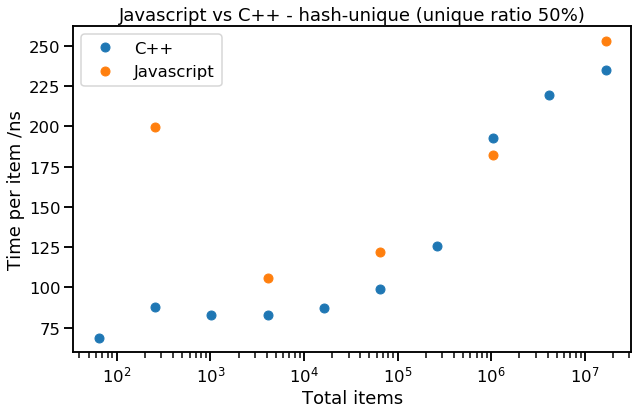

In [23]:
df_js = pd.read_csv('timings_js.csv.gz')
df_js['unique_ratio'] = df_js.n_unique / df_js.n_total
df_js['time'] = 1e9 * df_js.pop('time')
df_js['time_per_item'] = df_js.time / df_js.n_total
dfm_js = df_js.groupby(['n_total', 'n_unique', 'method']).median().reset_index()

d = dfm_js[['method', 'n_total', 'unique_ratio', 'time_per_item']]
display(pd.pivot_table(
    d[((d.n_total == d.n_total.max()) & (d.unique_ratio == 1)) |
      ((d.n_total == 2 ** 20) & (d.unique_ratio == .5)) |
      ((d.n_total == 2 ** 16) & (d.unique_ratio == d.unique_ratio.min()))
     ],
    values='time_per_item',
    index=['n_total', 'unique_ratio'],
    columns=['method']))

plt.figure(figsize=(10,6))
g = dfm[(dfm.unique_ratio == .5) & (dfm.method == 'hash_unique') & (dfm.key_type == 'int32')]
plt.plot(g.n_total, g.time_per_item, 'o')
g = dfm_js[(dfm_js.unique_ratio == .5) & (dfm_js.method == 'hash_unique')]
plt.plot(g.n_total, g.time_per_item, 'o')
plt.gca().set_xscale('log')
plt.legend(['C++', 'Javascript'])
plt.title('Javascript vs C++ - hash-unique (unique ratio 50%)')
plt.xlabel('Total items')
plt.ylabel('Time per item /ns');

# Java

,method,hash_unique,sort_unique
n_total,unique_ratio,,
65536,0.0625,37.750244,92.025757
1048576,0.5000,194.143295,138.404846
16777216,1.0000,368.976414,156.687856


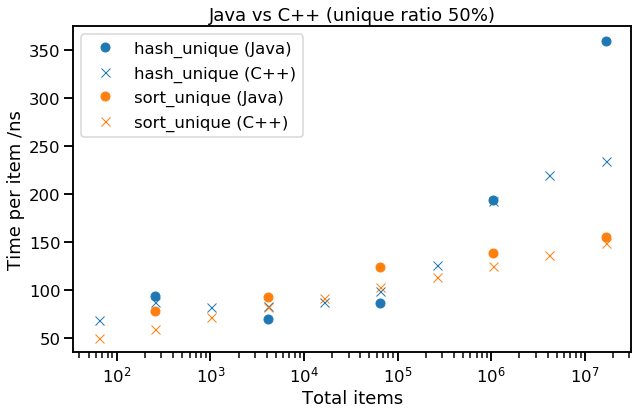

In [22]:
df_java = pd.read_csv('timings_java.csv.gz')
df_java['unique_ratio'] = df_java.n_unique / df_java.n_total
df_java['time'] = 1e9 * df_java.pop('time')
df_java['time_per_item'] = df_java.time / df_java.n_total
dfm_java = df_java.groupby(['n_total', 'n_unique', 'method']).median().reset_index()

d = dfm_java[['method', 'n_total', 'unique_ratio', 'time_per_item']]
display(pd.pivot_table(
    d[((d.n_total == d.n_total.max()) & (d.unique_ratio == 1)) |
      ((d.n_total == 2 ** 20) & (d.unique_ratio == .5)) |
      ((d.n_total == 2 ** 16) & (d.unique_ratio == d.unique_ratio.min()))
     ],
    values='time_per_item',
    index=['n_total', 'unique_ratio'],
    columns=['method']))

plt.figure(figsize=(10,6))
methods = ['hash_unique', 'sort_unique']
for method, color in zip(methods, sns.color_palette(n_colors=len(methods))):
    impls = ['Java', 'C++']
    for impl, marker in zip(impls, ['o', 'x']):
        g = (dfm[(dfm.unique_ratio == .5) & (dfm.method == method) & (dfm.key_type == 'int32')]
             if impl == 'C++' else
             dfm_java[(dfm_java.unique_ratio == .5) & (dfm_java.method == method)])
        plt.plot(g.n_total, g.time_per_item, marker, color=color)
    plt.gca().set_xscale('log')
    plt.legend([f'{method} ({impl})' for method in methods for impl in impls])
    plt.title('Java vs C++ (unique ratio 50%)')
    plt.xlabel('Total items')
    plt.ylabel('Time per item /ns')